<a href="https://colab.research.google.com/github/karencfisher/android-classifier/blob/main/notebook/cats_and_dogs_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tqdm import tqdm

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZWE16U/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
hist = model.fit(train_batches,
                 epochs=5,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 48s 53ms/step - loss: 0.0566 - accuracy: 0.9803 - val_loss: 0.0383 - val_accuracy: 0.9858
Epoch 2/5
582/582 [==============================] - 35s 54ms/step - loss: 0.0303 - accuracy: 0.9891 - val_loss: 0.0375 - val_accuracy: 0.9871
Epoch 3/5
582/582 [==============================] - 33s 51ms/step - loss: 0.0253 - accuracy: 0.9909 - val_loss: 0.0410 - val_accuracy: 0.9854
Epoch 4/5
582/582 [==============================] - 35s 54ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0368 - val_accuracy: 0.9901
Epoch 5/5
582/582 [==============================] - 33s 51ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0388 - val_accuracy: 0.9880


In [ ]:
tf.saved_model.save(model, 'CatsVsDogs')

### Covert the model and save it out

In [ ]:
export_file = 'CatsVsDogs'
convertor = tf.lite.TFLiteConverter.from_saved_model(export_file)
convertor.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = convertor.convert()
tflite_model_file = 'CatsVsDogs.tflite'

with open(tflite_model_file, 'wb') as FP:
  FP.write(tflite_model)

### Setup interpreter

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

predictions = []

### Make some predictions

In [ ]:
class_names = ['cat', 'dog']
test_batches = raw_test.map(format_image).batch(1)

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


## Show random sample of predictions

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

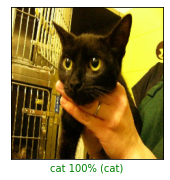

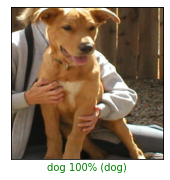

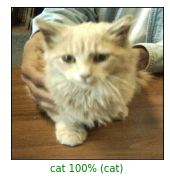

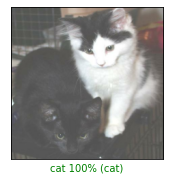

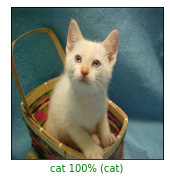

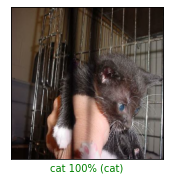

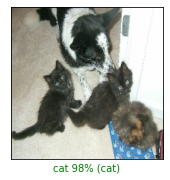

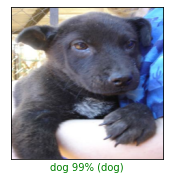

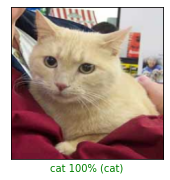

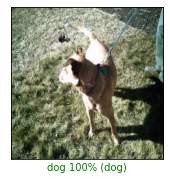

In [ ]:
sample = np.random.choice(range(0, 99), size=10)
for index in sample:
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

### Try a new uploaded image

In [ ]:
import cv2

img = cv2.imread('me2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, _ = format_image(img, '')

error: ignored

In [ ]:
interpreter.set_tensor(input_index, [img])
interpreter.invoke()
pred = interpreter.get_tensor(output_index)[0]
label = np.argmax(pred)

plt.imshow(img, cmap=plt.cm.binary)
plt.title(f'{class_names[label]} - {pred[label] * 100: .2f}%')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()
